# Стадия I

Программа принимает на вход скорости и координаты космических объектов и рассчитывает их положение и скорость в зависимости от времени методом численного решения уравнений Ньютона. Обоснован выбор разностной схемы и шага интеграции. Требуемая точность - отклонение от аналитической орбиты до 10 cм за неделю на орбитах высотой от 300 до 1200 км для модели с единственной силой - точечной гравитацией. Если это не достигается на стандартных типах данных, докажите, обсудим. Расчёт на GPU

Все расчёты в системе единиц СИ. Чтобы так не получилось.

Есть код, генерирующий случайные начальные условия для 21000 объектов. Круговые орбиты, высота распределена по Гауссу, средняя 800 км, дисперсия 200 км, плоскости - равномерно. Размеры объектов от 1 см до 10 м, распределены с pdf = 1/object_size

В коде есть интерфейс для простого добавления новых сил, действующих на объекты. Силы могут зависеть от времени, скорости и координат объекта, параметров объекта. В нём реализована элементарная модель гравитации, где Земля - шар.

Есть визуализатор, для заданных id объектов и интервалу времени, рисующий их траекторию картинкой. В отчёте есть траектории 10 случайных объектов на протяжении суток.


## 1 - Сравнение с аналитической орбитой

По заданию - Требуемая точность - отклонение от аналитической орбиты до 10 cм за неделю на орбитах высотой от 300 до 1200 км для модели с единственной силой - точечной гравитацией. 

In [1]:
%cd ..
!python3 setup.py --GPU=True

/data/ivpaharitonov/space_junk_simulator/space_junk_simulator
Build CPU version
Using cpp files:  ['/src/cpu/cpu_solver.cpp', '/src/python_package/py_wrapper_cpu.cpp', '/src/model.cpp']
Success!
Build GPU version
/data/ivpaharitonov/space_junk_simulator/space_junk_simulator/src/gpu/gpu_solver.cu(17): warning: variable "R" was declared but never referenced

/data/ivpaharitonov/space_junk_simulator/space_junk_simulator/src/gpu/gpu_solver.cu(38): warning: variable "M" was declared but never referenced

/data/ivpaharitonov/space_junk_simulator/space_junk_simulator/src/gpu/gpu_solver.cu(39): warning: variable "G" was declared but never referenced

/data/ivpaharitonov/space_junk_simulator/space_junk_simulator/src/gpu/gpu_solver.cu(124): warning: variable "dt1" was declared but never referenced

/data/ivpaharitonov/space_junk_simulator/space_junk_simulator/src/gpu/gpu_solver.cu(125): warning: variable "dh" was declared but never referenced

GPU build success! /data/ivpaharitonov/space_junk_si

In [2]:
# !pip3 install pykep --user

In [70]:
import pykep as pk
def kepler_sim(r, v, t, mu, N=60, units=1, color='b', legend=False, ax=None):
    """
    ax = plot_kepler(r, v, t, mu, N=60, units=1, color='b', legend=False, ax=None):
    - ax:		3D axis object created using fig.gca(projection='3d')
    - r:		initial position (cartesian coordinates)
    - v:		initial velocity (cartesian coordinates)
    - t:		propagation time
    - mu:		gravitational parameter
    - N:		number of points to be plotted along one arc
    - units:	the length unit to be used in the plot
    - color:	matplotlib color to use to plot the line
    - legend	when True it plots also the legend
    Plots the result of a keplerian propagation
    """

    from pykep import propagate_lagrangian
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D

    if ax is None:
        fig = plt.figure()
        axis = fig.gca(projection='3d')
    else:
        axis = ax

    # We define the integration time ...
    dt = t / (N - 1)

    # ... and calculate the cartesian components for r
    x = [0.0] * N
    y = [0.0] * N
    z = [0.0] * N

    # We calculate the spacecraft position at each dt
    for i in range(N):
        x[i] = r[0] / units
        y[i] = r[1] / units
        z[i] = r[2] / units
        r, v = pk.propagate_lagrangian(r, v, dt, mu)

    # And we plot
    if legend:
        label = 'ballistic arc'
    else:
        label = None
    axis.plot(x, y, z, c=color, label=label)

    if legend:
        axis.legend()

    if ax is None:  # show only if axis is not set
        plt.show()
    return axis, x, y, z

import numpy as np
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline


def simulate(sim, 
             x0, y0, z0, 
             vx0, vy0, vz0, 
             simulation_steps=10, time_step=1.0, plot_result=False):
    simulation_steps = int(simulation_steps)
    simulation_history = []
    objects_steps = []
    if plot_result:
        plt.figure(figsize=(12,12))
        ax = plt.axes(projection='3d')
    for simulation_step in tqdm_notebook(range(simulation_steps)):

        x_res, y_res, z_res, vx_res, vy_res, vz_res = \
        sim.run(x0, y0, z0, vx0, vy0, vz0, 
                    x0.size,vzsteps= int(1), timestep = float(time_step))


        x0, y0, z0, vx0, vy0, vz0 = x_res, y_res, z_res, vx_res, vy_res, vz_res
        simulation_history.append([x_res, y_res, z_res])
#     if plot_result:
#         n_time = len(simulation_history) //25 
#         print(simulation_history[::n_time])
#         ax.scatter3D(simulation_history[::n_time][0])
    return simulation_history
    

In [71]:
list(range(10)[::3])

[0, 3, 6, 9]

Зададимся следующим обьектом

In [72]:
x_obj = 25217.424362950926
y_obj = -496457.41386781185
z_obj = 650671.2495281389

vx_obj = 0.0014348032818816137
vy_obj = -0.00088002800475806
vz_obj = -0.0007270622299984097

MU =  5.972e24*6.67408e-11#3.986004418e14

In [73]:
import numpy as np
x_init = np.array([x_obj], dtype = np.float64)
y_init = np.array([y_obj], dtype = np.float64)
z_init = np.array([z_obj], dtype = np.float64)

vx_init = np.array([vx_obj], dtype = np.float64)
vy_init = np.array([vy_obj], dtype = np.float64)
vz_init = np.array([vz_obj], dtype = np.float64)

In [74]:
timestep = 1.0
week = (1/timestep)*3600*24*7 
simulation_time = 100
print('Simulation_time =', simulation_time, 'steps')

Simulation_time = 100 steps


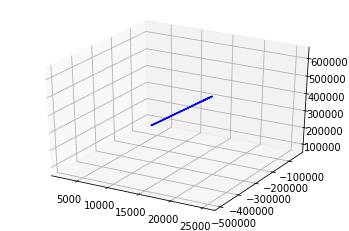

In [75]:
_ , x_keppler, y_keppler, z_keppler = \
kepler_sim([x_obj, y_obj, z_obj],
           [vx_obj, vy_obj, vz_obj], t=int(simulation_time) , mu =MU )

In [76]:
from src.python_package.space_junk_simulator import space_simulator
sim_gpu = space_simulator(gpu = True)
sim_cpu = space_simulator()

In [77]:
x0, y0, z0, vx0, vy0, vz0, x0 = \
x_init, y_init, z_init, vx_init, vy_init, vz_init, x_init

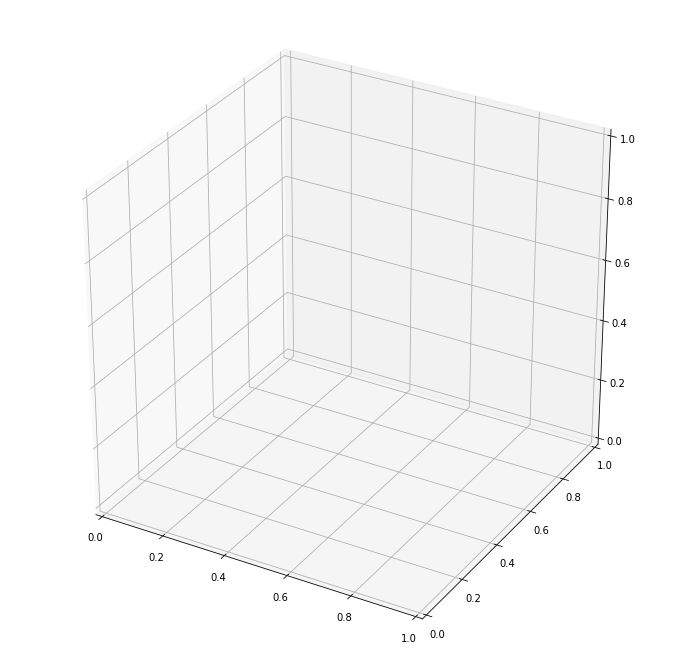

In [79]:
history = simulate(sim_cpu, x0, y0, z0, vx0, vy0, vz0, 
        simulation_steps=int(simulation_time), time_step=1.0,
                              plot_result=True)

In [102]:
traj_points = 10
object_idx = 0
history[::traj_points][0]

[array([25216.59611966]), array([-496441.08081023]), array([650649.84092352])]

In [89]:
plt.scatter(history[::10][0])

TypeError: scatter() missing 1 required positional argument: 'y'


[[array([25216.59611966]), array([-496441.08081023]), array([650649.84092352])], [array([25192.54386804]), array([-495967.45281548]), array([650972.50955607])], [array([25135.33820283]), array([-494841.1311339]), array([651947.91597099])], [array([25045.06142226]), array([-493063.73612123]), array([653574.48189877])], [array([24921.84789971]), array([-490637.91333963]), array([655849.59714568])], [array([24765.88114081]), array([-487567.27562106]), array([658769.66604252])], [array([24577.38810966]), array([-483856.29136704]), array([662330.20792052])], [array([24356.63279118]), array([-479510.15780955]), array([666525.99150947])], [array([24103.91551542]), array([-474534.78770887]), array([671351.09571703])], [array([23819.58555817]), array([-468937.05742219]), array([676798.73207567])], [array([23504.06271401]), array([-462725.23161289]), array([682860.82157039])], [array([23157.84262856]), array([-455909.06822573]), array([689527.73948791])], [array([22781.46552829]), array([-44849

TypeError: scatter() missing 1 required positional argument: 'ys'

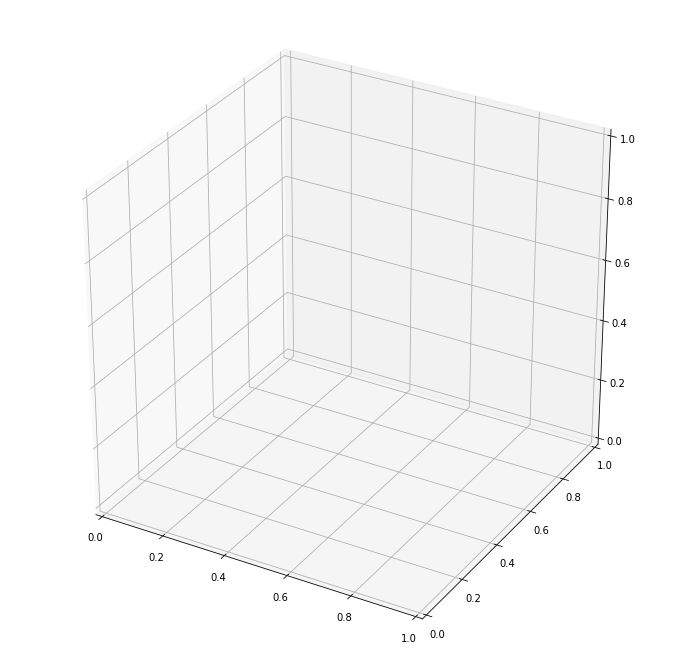

In [59]:
x_res, y_res, z_res = simulate(sim_cpu, x0, y0, z0, vx0, vy0, vz0, 
        simulation_steps=int(simulation_time), time_step=1.0,
                              plot_result=True)

In [11]:
x_keppler[-1], y_keppler[-1], z_keppler[-1]

(22281.816828189116, -438663.41710263904, 574924.756968858)

In [12]:
x_res, y_res, z_res

(array([15636.91521525]), array([-307842.79173538]), array([835608.57202093]))

In [23]:
print(x_keppler[len(x_keppler)//2+1], 
      y_keppler[len(x_keppler)//2+1],
      z_keppler[len(x_keppler)//2+1])

15833.185764550726 -311709.86591474485 408535.8904199866


Посмотрим на разницу за неделю

In [ ]:
 x_keppler[-1]-x_res, y_keppler[-1]-y_res, z_keppler[-1]-z_res

(array([6644.90161294]), array([-130820.62536725]), array([-260683.81505207]))

# Несколько обьектов

In [ ]:
from src.utils import *

In [ ]:
N = 21000

space_objects = generate_object_states(N)

    
import pandas as pd
a = pd.DataFrame(space_objects).values

object_id = a[:, 0]
x_batch_init = a[:, 6].astype(np.float64)
y_batch_init = a[:, 7].astype(np.float64)
z_batch_init = a[:, 8].astype(np.float64)

vx_batch_init = a[:, 3].astype(np.float64)
vy_batch_init = a[:, 4].astype(np.float64)
vz_batch_init = a[:, 5].astype(np.float64)

In [ ]:
x0, y0, z0, vx0, vy0, vz0, x0 = \
x_batch_init, y_batch_init, z_batch_init, vx_batch_init, vy_batch_init, vz_batch_init, x_batch_init

In [ ]:
from src.python_package.space_junk_simulator import space_simulator
sim_gpu = space_simulator(gpu = True)
sim_cpu = space_simulator()

In [ ]:
%%time
x_res, y_res, z_res, vx_res, vy_res, vz_res = \
sim_gpu.run(x0, y0, z0, vx0, vy0, vz0, x0.size, vzsteps= int(1), timestep = float(0.1))

CPU times: user 239 ms, sys: 303 ms, total: 542 ms
Wall time: 657 ms


In [ ]:
timestep = 1.0
day = (1/timestep)*3600*24 
simulation_time = day
print('Simulation_time =', simulation_time, 'steps')

Simulation_time = 86400.0 steps


In [ ]:
simulate(sim_cpu, x0, y0, z0, vx0, vy0, vz0, 
         simulation_steps=simulation_time, time_step=timestep)